In [1]:
import math
import time
import gc
import os
import re


import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.animation import FuncAnimation, PillowWriter


/home/wellscrosby/miniconda3/envs/mlp/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wellscrosby/miniconda3/envs/mlp/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
gc.collect()

# assert torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
print(device)

cuda


In [4]:
kernel_size = 31

In [5]:
def isolated_plot_grid(x):
    plt.figure(figsize=(10, 10))
    plt.imshow(x[0, 0].cpu().detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.title('Grids')
    plt.show()

In [6]:
class GridCell(nn.Module):
    def __init__(self, kernel_size):
        super(GridCell, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=kernel_size, stride=1, padding=kernel_size//2, bias=False, padding_mode="circular")  # Set padding to 0
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=kernel_size, stride=1, padding=kernel_size//2, bias=False, padding_mode="circular")  # Set padding to 0
        
    def forward(self, x, static_kernel, direction_kernel, mask):
        self.conv1.weight.data = static_kernel.to(device)
        self.conv2.weight.data = direction_kernel.to(device)
        
        direction_result = self.conv2(x)

        x = self.conv1(x)
        
        x[0, 0, mask] = direction_result[0, 0, mask]
            
        return x

# Instantiate the model
model = GridCell(kernel_size).to(device)
print(model)

GridCell(
  (conv1): Conv2d(1, 1, kernel_size=(31, 31), stride=(1, 1), padding=(15, 15), bias=False, padding_mode=circular)
  (conv2): Conv2d(1, 1, kernel_size=(31, 31), stride=(1, 1), padding=(15, 15), bias=False, padding_mode=circular)
)


In [7]:
def gaussian(x, mu, sigma):
    # return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

    return (1 / (sigma * (2 * np.pi)**0.5)) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

def center_surround(distance, width):
    factor = (3 * np.pi) / 2
    # return -gaussian((distance / width) * factor, 0, 5) + gaussian((distance / width) * factor, 0, 1) 
    return np.cos((distance / width) * factor) * gaussian((distance / width) * factor, 0, 2.9)
    # return (np.exp(-((distance*(2/width)) ** 2)) -0.25) * 2
    
def simple_gaussian(x, sigma):
    return np.exp(-((x) ** 2) / (2 * sigma ** 2))

def make_filter(size, deviation_x, deviation_y):
    x = torch.zeros_like(model.conv1.weight)
    center = (size - 1) / 2
    
    # print(((center - center) ** 2 + (j - center) ** 2) ** 0.5)
    for i in range(size):
        for j in range(size):
            dist_from_center = ((i - center + deviation_x) ** 2 + (j - center + deviation_y) ** 2) ** 0.5
            
            if dist_from_center > center:
                x[0, 0, i, j] = 0
                # print(i, j)
                # print("-------")
            else:
                x[0, 0, i, j] = center_surround(dist_from_center, center)
    mean = torch.mean(x)
    x = x - mean
    
    for i in range(size):
        for j in range(size):
            dist_from_center = ((i - center + deviation_x) ** 2 + (j - center + deviation_y) ** 2) ** 0.5
            
            if dist_from_center > center:
                x[0, 0, i, j] = 0
                
    return x

def make_sharper_filter(size):
    x = -torch.ones_like(model.conv1.weight)
    center = ((size - 1) / 2)
    
    # print(((center - center) ** 2 + (j - center) ** 2) ** 0.5)
    for i in range(size):
        for j in range(size):
            dist_from_center = ((i - center) ** 2 + (j - center) ** 2) ** 0.5
            x[0, 0, i, j] += 2 * simple_gaussian(dist_from_center, 1)
    mean = torch.mean(x)
    x = x - mean
    return x

tensor(-6.3734, device='cuda:0')


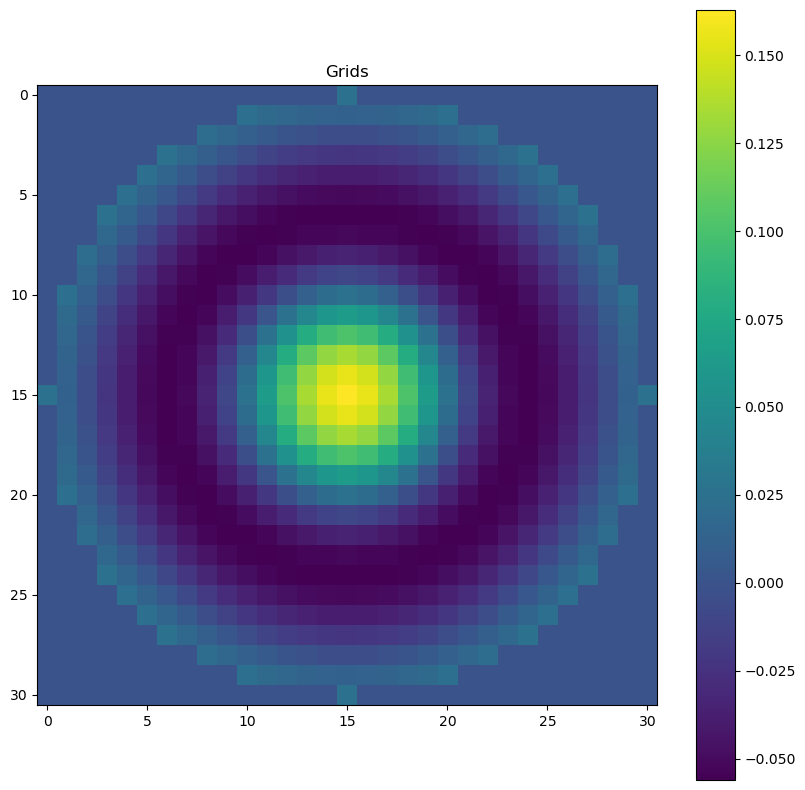

tensor(0., device='cuda:0')


In [8]:
# Manually set the weights and biases of the conv1 layer
with torch.no_grad():
    weights = make_filter(kernel_size, 0, 0).to(device)
    print(weights.sum())
    model.conv1.weight = nn.Parameter(weights)
    # model.conv1.bias = nn.Parameter(torch.zeros_like(model.conv1.bias))
    
isolated_plot_grid(model.conv1.weight)

print(weights[0,0,0,0])

In [9]:
def find_peaks(x):
    peaks = []
    for i in range(1, x.shape[0] - 1):
        if x[i] > x[i - 1] and x[i] > x[i + 1]:
            peaks.append(i)
    return peaks

In [ ]:
torch.cuda.empty_cache()
gc.collect()

portion_update = 0.1
random_factor = 0.0001

width = 200
# height = int(width * np.sqrt(3)/2)
height = 200
num_iters = 1000

# grids = torch.rand(1, 1, grid_size, grid_size).to(device) / np.sqrt(2)
# grids = torch.rand(1, 1, height, width).to(device)
grids = torch.zeros(1, 1, height, width).to(device)
# grids[0, 0, grid_size//2, grid_size//2] = 1

# model(grids)

# Forward pass
with torch.no_grad():
    for i in tqdm(range(num_iters), desc="Processing"):
        # print(grids.shape)
        
        random_deviation = torch.rand(1, 1, height, width).to(device) * random_factor
        grids = (1 - portion_update) * grids + portion_update * (model(grids) + random_deviation)
        
        
        
        grids = (1 - portion_update) * grids + portion_update * model(grids)
        
        
        # normalize
        grids = (grids - grids.min()) / (grids.max() - grids.min())
        # in grid center add some value
        # grids[0, 0, int(height* (i/num_iters)), :] = 1
        
        # deviation = int(10 * (i/num_iters))
        
        # for j in range(0, height, 20):
        #     for k in range(0, width, 20):
        #         grids[0, 0, (j + deviation)%height, (k+ deviation)% width] = 1
        
        
        if i % 200 == 0:
            isolated_plot_grid(grids)
            slice_across = grids[0,0, height//2, :].cpu().detach().numpy()
            plt.plot(slice_across)
            print(find_peaks(slice_across))

In [ ]:
def get_next_filename(directory, base_name, extension):
    files = os.listdir(directory)
    pattern = re.compile(rf"{base_name}_(\d+){extension}")
    numbers = [int(pattern.match(f).group(1)) for f in files if pattern.match(f)]
    next_number = max(numbers, default=0) + 1
    return os.path.join(directory, f"{base_name}_{next_number}{extension}")

In [ ]:
def plot_grid(grids, ax):
    ax.clear()
    im = ax.imshow(grids[0, 0].cpu().detach().numpy(), cmap='viridis')
    return im

torch.cuda.empty_cache()
gc.collect()

portion_update = 0.1
random_factor = 0.0001

grid_size = 100
num_iters = 10000
num_frames = 100
num_deviation = 30

iters_per_frame = num_iters // num_frames

# grids = torch.zeros(1, 1, grid_size, grid_size).to(device)
grids = torch.rand(1, 1, grid_size, grid_size)


fig, ax = plt.subplots(figsize=(10, 10))

progress_bar = tqdm(total=num_frames, desc="Processing frames")

def update(frame):
    global grids
    
    for i in range(iters_per_frame):
        cur_iter = (frame * iters_per_frame) + i
        
        random_deviation = torch.rand(1, 1, grid_size, grid_size).to(device) * random_factor
        grids = (1 - portion_update) * grids + portion_update * (model(grids) + random_deviation)
        grids = (grids - grids.min()) / (grids.max() - grids.min())

        # index = int((frame/num_iters) * 2)
        # grids[0, 0, (index - 1)%grid_size, :] = 0.8
        # grids[0, 0, index, :] = 1
        # grids[0, 0, (index + 1)%grid_size, :] = 0.8
        
        # grids[0, 0, (grid_size//2) - 1, :] = 0.8
        # grids[0, 0, grid_size//2, :] = 1
        # grids[0, 0, (grid_size//2) + 1, :] = 0.8
        
        deviation = int(num_deviation * (cur_iter/num_iters))
        
        for j in range(0, grid_size, 20):
            for k in range(0, grid_size, 20):
                grids[0, 0, (j + deviation)%grid_size, (k+ deviation)% grid_size] = 1
                grids[0, 0, ((j + deviation + 10)%grid_size), ((k+ deviation + 10)% grid_size)] = 1
            
    im = plot_grid(grids, ax)
    
    progress_bar.update(1)
    progress_bar.set_description(f"Processing frame {frame + 1}/{num_frames}")
    
    return [im]

ani = FuncAnimation(fig, update, frames=num_frames, blit=True)

# Save the animation as an MP4 file
output_directory = 'videos'
base_filename = 'grids_evolution'
file_extension = '.mp4'
output_filename = get_next_filename(output_directory, base_filename, file_extension)
ani.save(output_filename, fps=30)

plt.close()

In [9]:
import pygame

torch.cuda.empty_cache()
gc.collect()

portion_update = 1
random_factor = 0.9

iters_per_frame = 10
spacing = int(kernel_size * (4/5))
half_spacing = spacing // 2
grid_size = 100 #spacing * 4
move_per_frame = 2

half_kernel = (kernel_size - 1) // 2

center = (grid_size) // 2

print(spacing, half_spacing)

grids = torch.rand(1, 1, grid_size, grid_size).to(device)

# Initialize pygame
pygame.init()
window_size = (800, 800)
screen = pygame.display.set_mode(window_size)
pygame.display.set_caption("Grid Evolution")

# Initialize font
font = pygame.font.SysFont(None, 36)

kernel = make_filter(kernel_size, 0,  0)

# Allow user to choose the number of points to be masked
num_masked_points = 1000  # You can change this value as needed

# Generate random positions for the masked points
masked_positions = torch.randint(0, grid_size, (num_masked_points, 2))

# Create the mask with the specified number of masked points
mask = torch.zeros((grid_size, grid_size), dtype=torch.bool).to(device)

for pos in masked_positions:
    mask[pos[0], pos[1]] = True
    
def update_grid(grids, deviation, power):
    with torch.no_grad():
        deviation_x = deviation[0]
        deviation_y = deviation[1]
        
        point_kernel = make_filter(kernel_size, deviation_y,  deviation_x).to(device)
        
        # print(deviation_x, deviation_y)
        
        # print(point_kernel.shape) 
        for _ in range(iters_per_frame):
            random_deviation = torch.rand(1, 1, grid_size, grid_size).to(device) * random_factor
            grids = (1 - portion_update) * grids + portion_update * (model(grids, kernel, point_kernel, mask) + random_deviation)
            grids = (grids - grids.min()) / (grids.max() - grids.min())

            grids = grids**power
            
            # for deviation_x, deviation_y in deviations:
            #     deviation_x = int(deviation_x)
            #     deviation_y = int(deviation_y)
            #     grids[0, 0, (deviation_y) % grid_size, (deviation_x) % grid_size] = 1
            #     grids[0, 0, (deviation_y+1) % grid_size, (deviation_x) % grid_size] = 0.9
            #     grids[0, 0, (deviation_y) % grid_size, (deviation_x+1) % grid_size] = 0.9
            #     grids[0, 0, (deviation_y-1) % grid_size, (deviation_x) % grid_size] = 0.9
            #     grids[0, 0, (deviation_y) % grid_size, (deviation_x-1) % grid_size] = 0.9
            #     grids[0, 0, (deviation_y+1) % grid_size, (deviation_x+1) % grid_size] = 0.8
            #     grids[0, 0, (deviation_y-1) % grid_size, (deviation_x-1) % grid_size] = 0.8
            #     grids[0, 0, (deviation_y+1) % grid_size, (deviation_x-1) % grid_size] = 0.8
            #     grids[0, 0, (deviation_y-1) % grid_size, (deviation_x+1) % grid_size] = 0.8
            
        # current_sum = grids.sum()
    return grids

running = True
clock = pygame.time.Clock()

power = 1

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_ESCAPE:
                running = False
    deviation = np.zeros(2)

    keys = pygame.key.get_pressed()
    if keys[pygame.K_a]:
        deviation[1] -= move_per_frame
    if keys[pygame.K_d]:
        deviation[1] += move_per_frame
    if keys[pygame.K_w]:
        deviation[0] -= move_per_frame
    if keys[pygame.K_s]:
        deviation[0] += move_per_frame

    # if keys[pygame.K_LEFT]:
    #     deviation[1] -= move_per_frame
    # if keys[pygame.K_RIGHT]:
    #     deviation[1] += move_per_frame
    # if keys[pygame.K_UP]:
    #     deviation[0] -= move_per_frame
    # if keys[pygame.K_DOWN]:
    #     deviation[0] += move_per_frame
        
    if keys[pygame.K_LSHIFT]:
        power += 0.01
    if keys[pygame.K_LCTRL]:
        power -= 0.01

    grids = update_grid(grids, deviation, power)
    grid_np = grids[0, 0].cpu().detach().numpy()**1
    scaled_grid = (grid_np * 255).astype(np.uint8)
    rgb_grid = np.stack((scaled_grid,) * 3, axis=-1)
    rgb_grid[:, :, 0] = (rgb_grid[:, :, 0].astype(np.float32) * 0.5).astype(np.uint8)

    # Render the grid using pygame
    surface = pygame.surfarray.make_surface(rgb_grid)
    surface = pygame.transform.scale(surface, window_size)
    screen.blit(surface, (0, 0))

    # Render the text
    text_surface = font.render(f"Power: {power}", True, (255, 255, 255))
    screen.blit(text_surface, (10, 10))

    pygame.display.flip()
    clock.tick(30)  # Limit to 30 frames per second

pygame.quit()


pygame 2.2.0 (SDL 2.26.5, Python 3.11.6)
Hello from the pygame community. https://www.pygame.org/contribute.html
24 12
